#Imports

In [2]:
import torch
import torch.nn as nn
# plot the accuracy heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
# add pd to the path
import sys
# import pandas
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  ConfusionMatrixDisplay,confusion_matrix
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
from google.colab import files
import io
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
import re
from pandas import Series,DataFrame
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
!pip install transformers
from transformers import BertTokenizer
from transformers import BertModel
from torch.optim import Adam
from tqdm import tqdm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 8.3 MB/s eta 0:00:00


In [ ]:
!nvidia-smi -L
 

GPU 0: Tesla T4 (UUID: GPU-1f2bdea0-c9a3-0844-a509-497294be2301)


In [ ]:
!nvidia-smi -L


GPU 0: Tesla T4 (UUID: GPU-1f2bdea0-c9a3-0844-a509-497294be2301)


In [ ]:
 !nvidia-smi

Wed Jan 25 16:58:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    24W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!sudo nvidia-smi -pm 1 


Failed to initialize NVML: Driver/library version mismatch


In [ ]:
# !pip install numba

# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

#Data Loading

In [ ]:
# mount drive from google drive to colab using https://drive.google.com/file/d/1zbCL7aktBqAgndgkvinI27XntHxfoGHn/view?usp=share_link
from google.colab import drive
drive.mount('/content/drive')
# read data from google drive
import pandas as pd
read_data = pd.read_csv('/content/drive/My Drive/IMDB Dataset.csv')


Mounted at /content/drive


In [ ]:
read_data['sentiment'].value_counts()
# print the number of instances of each class
print(read_data['sentiment'].value_counts())
read_data.describe()

positive    25000
negative    25000
Name: sentiment, dtype: int64


,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
read_data.dropna(axis = 0, how = 'any', inplace = True)
read_data.to_csv('IMDB Dataset_parsed.csv', index = False)

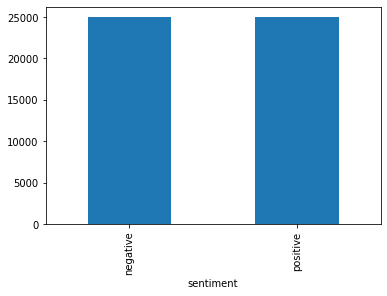

In [ ]:
read_data.groupby(['sentiment']).size().plot.bar()

#Balancing dataset

In [ ]:
# get the indices of the majority class positive
indices = read_data[read_data['sentiment'] == 'positive'].index

# get the size of the minority class negative
sizen = len(read_data[read_data['sentiment'] == 'negative'])
sizep = len(read_data[read_data['sentiment'] == 'positive'])

# randomly sample the indices of the majority class positive
indices = np.random.choice(indices, sizen-sizep, replace=False)

# delete from the majority class g
read_data = read_data.drop(indices)
print(read_data['sentiment'].value_counts())
read_data.describe()

positive    25000
negative    25000
Name: sentiment, dtype: int64


,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


#Splitting the data

In [ ]:
train_list = [] 
test_list = []
val_list = []
grouped_df = read_data.groupby('sentiment')

# ITERATE THROUGH EACH SUBSET DF
for i, g in grouped_df:
    # STRATIFY THE g (CLASS) DATA FRAME
    train, test, val = np.split(g, [int(.7 * len(g)), int(.9 * len(g))])

    train_list.append(train); test_list.append(test); val_list.append(val)

train_data = pd.concat(train_list)
test_data = pd.concat(test_list)
validation_data = pd.concat(val_list)

In [ ]:
print(train_data['sentiment'].value_counts())


negative    17500
positive    17500
Name: sentiment, dtype: int64


In [ ]:
print(test_data['sentiment'].value_counts())


negative    5000
positive    5000
Name: sentiment, dtype: int64


In [ ]:
print(validation_data['sentiment'].value_counts())


negative    2500
positive    2500
Name: sentiment, dtype: int64


#BERT


## Dataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'positive':0,
          'negative':1,
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['sentiment']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['review']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

## Model

In [ ]:
from torch.nn.modules import linear
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout_1 = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(768,512)
        self.dropout_2 = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(512, 256)
        self.dropout_3 = nn.Dropout(dropout)
        self.linear_3 = nn.Linear(256, 128)
        self.dropout_4 = nn.Dropout(dropout)
        self.linear_4= nn.Linear(128, 64)
        self.dropout_5 = nn.Dropout(dropout)
        self.linear_5= nn.Linear(64, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout_1(pooled_output)
        linear_output_1 = self.linear_1(dropout_output)
        dropout_output_1 = self.dropout_2(linear_output_1)
        linear_output_2 = self.linear_2(dropout_output_1)
        dropout_output_2 = self.dropout_3(linear_output_2)
        linear_output_3 = self.linear_3(dropout_output_2)
        dropout_output_3 = self.dropout_4(linear_output_3)
        linear_output_4 = self.linear_4(dropout_output_3)
        dropout_output_4 = self.dropout_5(linear_output_4)
        linear_output_5 = self.linear_5(dropout_output_4)
        final_layer = self.relu(linear_output_5)

        return final_layer

In [ ]:
import shutil, sys   
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

# Loss as a metric

In [ ]:
epochs = [1,2,3,4,5]
test_acc =[]
val_acc=[]

from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs,checkpoint_path , best_model_path , valid_loss_min_input):
    test_acc.clear()
    val_acc.clear()
    valid_loss_min = valid_loss_min_input 
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=4)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in epochs:
            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                # train_label_squeeze = train_label
                # train_label = train_label.unsqueeze(1)
                # train_label = train_label.float()
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)
                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num } | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            test_acc.append(total_acc_train / len(train_data))
            val_acc.append(total_acc_val / len(val_data))
          
            valid_loss = total_loss_val/len(val_data)
            checkpoint = {
                'epoch': epoch_num ,
                'valid_loss_min': valid_loss,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate
                }
            save_ckp(checkpoint, False, checkpoint_path, best_model_path)

            if valid_loss <= valid_loss_min:
              print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
              # save checkpoint as best model
              save_ckp(checkpoint, True, checkpoint_path, best_model_path)
              valid_loss_min = valid_loss
                  
# EPOCHS = 5
model = BertClassifier()
LR = 1e-6
checkpoint_path = '/content/drive/MyDrive/bert/checkpoints/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodel/model.pt'

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
EPOCHS =[1,2,3,4,5]
train(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model,np.Inf)

100%|██████████| 8750/8750 [59:40<00:00,  2.44it/s]


Epochs: 1 | Train Loss:  0.150                 | Train Accuracy:  0.673                 | Val Loss:  0.093                 | Val Accuracy:  0.900
Validation loss decreased (inf --> 0.093402).  Saving model ...


100%|██████████| 8750/8750 [1:00:33<00:00,  2.41it/s]


Epochs: 2 | Train Loss:  0.068                 | Train Accuracy:  0.919                 | Val Loss:  0.061                 | Val Accuracy:  0.919
Validation loss decreased (0.093402 --> 0.060927).  Saving model ...


100%|██████████| 8750/8750 [1:00:32<00:00,  2.41it/s]


Epochs: 3 | Train Loss:  0.046                 | Train Accuracy:  0.945                 | Val Loss:  0.056                 | Val Accuracy:  0.921
Validation loss decreased (0.060927 --> 0.055805).  Saving model ...


 47%|████▋     | 4131/8750 [28:35<32:14,  2.39it/s]

In [ ]:
# loss
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    lr =  checkpoint['learning_rate']
    # return model, optimizer, epoch value, min validation loss , lr
    return model, optimizer, checkpoint['epoch'], valid_loss_min , lr

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch, valid_loss_min, lr = load_ckp(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1, 7)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(EPOCHS)

range(4, 7)


In [ ]:
train(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_loss_min)

100%|██████████| 8750/8750 [57:36<00:00,  2.53it/s]


Epochs: 4 | Train Loss:  0.033                 | Train Accuracy:  0.964                 | Val Loss:  0.060                 | Val Accuracy:  0.922


100%|██████████| 8750/8750 [57:34<00:00,  2.53it/s]


Epochs: 5 | Train Loss:  0.022                 | Train Accuracy:  0.980                 | Val Loss:  0.066                 | Val Accuracy:  0.924


 29%|██▉       | 2536/8750 [16:41<40:26,  2.56it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch, valid_loss_min, lr = load_ckp(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1, 7)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


range(6, 7)


In [ ]:
train(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_loss_min)

100%|██████████| 8750/8750 [55:11<00:00,  2.64it/s]


Epochs: 6 | Train Loss:  0.014                 | Train Accuracy:  0.989                 | Val Loss:  0.079                 | Val Accuracy:  0.922


In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch, valid_loss_min, lr = load_ckp(checkpoint_path, model, optimizer)
EPOCHS = [start_epoch+1]
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[7]


In [ ]:
train(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_loss_min)

100%|██████████| 8750/8750 [55:07<00:00,  2.65it/s]


Epochs: 7 | Train Loss:  0.010                 | Train Accuracy:  0.993                 | Val Loss:  0.088                 | Val Accuracy:  0.921


In [ ]:
def load_model(bestmodel_fpath, model, optimizer):
    """
    bestmodel_fpath: path to save best model
    model: model that we want to load best model parameters into
    optimizer: optimizer we defined in previous training
    """
    # load best model
    best_model = torch.load(bestmodel_fpath)
    # initialize state_dict from best model to model
    model.load_state_dict(best_model['state_dict'])
    # initialize optimizer from best model to optimizer
    optimizer.load_state_dict(best_model['optimizer'])
    # initialize valid_loss_min from best model to valid_loss_min
    valid_loss_min = best_model['valid_loss_min']
    lr =  best_model['learning_rate']
    # return model, optimizer, epoch value, min validation loss , lr
    return model, optimizer, best_model['epoch'], valid_loss_min , lr


In [ ]:
model_lr5 = BertClassifier()
LR_lr5 = 1e-5
checkpoint_path_lr5 = '/content/drive/MyDrive/bert/checkpoints_lr1.e5/check.pt'
best_model_lr5 = '/content/drive/MyDrive/bert/bestmodel_lr1.e5/model.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
EPOCHS_lr5 =[1,2,3,4,5]
train(model_lr5, train_data, validation_data, LR_lr5, EPOCHS_lr5,checkpoint_path_lr5, best_model_lr5,np.Inf)

100%|██████████| 8750/8750 [57:05<00:00,  2.55it/s]


Epochs: 1 | Train Loss:  0.117                 | Train Accuracy:  0.720                 | Val Loss:  0.061                 | Val Accuracy:  0.898
Validation loss decreased (inf --> 0.061070).  Saving model ...


100%|██████████| 8750/8750 [57:46<00:00,  2.52it/s]


Epochs: 2 | Train Loss:  0.046                 | Train Accuracy:  0.934                 | Val Loss:  0.048                 | Val Accuracy:  0.930
Validation loss decreased (0.061070 --> 0.047834).  Saving model ...


100%|██████████| 8750/8750 [57:50<00:00,  2.52it/s]


Epochs: 3 | Train Loss:  0.023                 | Train Accuracy:  0.971                 | Val Loss:  0.054                 | Val Accuracy:  0.923


100%|██████████| 8750/8750 [57:47<00:00,  2.52it/s]


Epochs: 4 | Train Loss:  0.013                 | Train Accuracy:  0.985                 | Val Loss:  0.065                 | Val Accuracy:  0.928


100%|██████████| 8750/8750 [57:45<00:00,  2.52it/s]


Epochs: 5 | Train Loss:  0.009                 | Train Accuracy:  0.991                 | Val Loss:  0.089                 | Val Accuracy:  0.926


In [ ]:
# reload ckp and start training from the last epoch
model_lr5 = BertClassifier()
optimizer_lr5 = Adam(model.parameters(), lr= LR_lr5)
model_lr5, optimizer_lr5, start_epoch, valid_loss_min_lr5, LR_lr5 = load_ckp(checkpoint_path_lr5, model_lr5, optimizer_lr5)
EPOCHS_lr5 = range(start_epoch+1,8)
print(EPOCHS_lr5)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


range(6, 8)


In [ ]:
train(model_lr5, train_data, validation_data, LR_lr5, EPOCHS_lr5,checkpoint_path_lr5, best_model_lr5, valid_loss_min_lr5)

 36%|███▌      | 3158/8750 [20:47<36:42,  2.54it/s]

In [ ]:
train(model_lr5, train_data, validation_data, LR_lr5, EPOCHS_lr5,checkpoint_path_lr5, best_model_lr5, valid_loss_min_lr5)

# Accuracy as a metric

In [ ]:
  def load_model_accuracy(bestmodel_fpath, model, optimizer):
      """
      bestmodel_fpath: path to save best model
      model: model that we want to load best model parameters into
      optimizer: optimizer we defined in previous training
      """
      # load best model
      best_model = torch.load(bestmodel_fpath)
      # initialize state_dict from best model to model
      model.load_state_dict(best_model['state_dict'])
      # initialize optimizer from best model to optimizer
      optimizer.load_state_dict(best_model['optimizer'])
      # initialize valid_loss_min from best model to valid_loss_min
      valid_loss_min = best_model['valid_loss_min']
      valid_accuracy_max=best_model['valid_accuracy_max']
      lr =  best_model['learning_rate']
      # return model, optimizer, epoch value, min validation loss , lr
      return model, optimizer, best_model['epoch'], valid_accuracy_max , lr

In [ ]:
# accuracy
def load_ckp_accuracy(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    valid_accuracy_max=checkpoint['valid_accuracy_max']
    lr =  checkpoint['learning_rate']
    # return model, optimizer, epoch value, min validation loss , lr
    return model, optimizer, checkpoint['epoch'], valid_accuracy_max , lr

In [ ]:
epochs = [1,2,3,4,5,6,7,8,9,10]
test_acc =[]
val_acc=[]

from torch.optim import Adam
from tqdm import tqdm

def train_accuracy(model, train_data, val_data, learning_rate, epochs,checkpoint_path , best_model_path , valid_accuracy_max_input):
    test_acc.clear()
    val_acc.clear()
    valid_accuracy_max=valid_accuracy_max_input
    # valid_loss_min = valid_loss_min_input 
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=4)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in epochs:
            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                # train_label_squeeze = train_label
                # train_label = train_label.unsqueeze(1)
                # train_label = train_label.float()
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)
                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num } | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            test_acc.append(total_acc_train / len(train_data))
            val_acc.append(total_acc_val / len(val_data))
          
            valid_loss = total_loss_val/len(val_data)
            valid_accuracy=total_acc_val / len(val_data)
            checkpoint = {
                'epoch': epoch_num ,
                'valid_loss_min': valid_loss,
                'valid_accuracy_max':total_acc_val / len(val_data),
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate
                }
            save_ckp(checkpoint, False, checkpoint_path, best_model_path)

            if valid_accuracy >= valid_accuracy_max:
              print('Validation Accuracy increased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_accuracy_max,valid_accuracy))
              # save checkpoint as best model
              save_ckp(checkpoint, True, checkpoint_path, best_model_path)
              # valid_loss_min = valid_loss
              valid_accuracy_max=valid_accuracy
                  
# EPOCHS = 5
model = BertClassifier()
LR = 5e-6
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsacc/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelacc/model.pt'

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Training

## 5e-4

In [ ]:
LR = 5e-4
epochs = [1,2,3,4,5,6,7,8,9,10]
test_acc =[]
val_acc=[]
train_acc=[]
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsacc/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelacc/model.pt'


In [ ]:
model = BertClassifier()
LR = 5e-4
optimizer = Adam(model.parameters(), lr= LR)
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8750/8750 [54:48<00:00,  2.66it/s]


Epochs: 1 | Train Loss:  0.174                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (-inf --> 0.500000).  Saving model ...


100%|██████████| 8750/8750 [54:19<00:00,  2.68it/s]


Epochs: 2 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


100%|██████████| 8750/8750 [54:17<00:00,  2.69it/s]


Epochs: 3 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


100%|██████████| 8750/8750 [54:17<00:00,  2.69it/s]


Epochs: 4 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


100%|██████████| 8750/8750 [54:17<00:00,  2.69it/s]


Epochs: 5 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


100%|██████████| 8750/8750 [54:18<00:00,  2.69it/s]


Epochs: 6 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


 31%|███       | 2705/8750 [16:47<37:26,  2.69it/s]

In [ ]:
#epoch 3
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)


100%|██████████| 8750/8750 [54:21<00:00,  2.68it/s]


Epochs: 7 | Train Loss:  0.174                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500200).  Saving model ...


100%|██████████| 8750/8750 [54:14<00:00,  2.69it/s]


Epochs: 8 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [54:16<00:00,  2.69it/s]


Epochs: 9 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [54:18<00:00,  2.69it/s]


Epochs: 10 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


In [ ]:
train_acc=[0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500]
val_acc=[0.500,0.500,0.50,0.500,0.500,0.500,0.500,0.500,0.500,0.500]

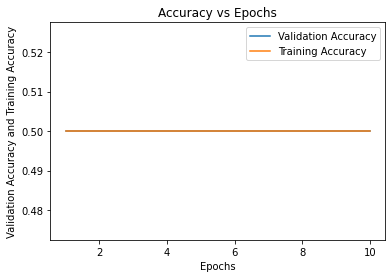

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

## 5e-6

In [ ]:
LR = 5e-6
epochs = [1,2,3,4,5,6,7,8,9,10]
test_acc =[]
val_acc=[]
train_acc=[]

checkpoint_path = '/content/drive/MyDrive/bert/checkpointsacclr5e-6/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelacclr5e-6/model.pt'

In [ ]:
model = BertClassifier()
LR = 5e-6
optimizer = Adam(model.parameters(), lr= LR)
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8750/8750 [58:08<00:00,  2.51it/s]


Epochs: 1 | Train Loss:  0.080                 | Train Accuracy:  0.854                 | Val Loss:  0.051                 | Val Accuracy:  0.926
Validation Accuracy increased (-inf --> 0.926000).  Saving model ...


100%|██████████| 8750/8750 [58:04<00:00,  2.51it/s]


Epochs: 2 | Train Loss:  0.035                 | Train Accuracy:  0.955                 | Val Loss:  0.052                 | Val Accuracy:  0.923


 39%|███▉      | 3427/8750 [22:39<35:34,  2.49it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.prediction

range(3, 11)


In [ ]:
#epoch 3
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [55:30<00:00,  2.63it/s]


Epochs: 3 | Train Loss:  0.015                 | Train Accuracy:  0.984                 | Val Loss:  0.064                 | Val Accuracy:  0.928
Validation Accuracy increased (0.926000 --> 0.928000).  Saving model ...


100%|██████████| 8750/8750 [55:23<00:00,  2.63it/s]


Epochs: 4 | Train Loss:  0.008                 | Train Accuracy:  0.992                 | Val Loss:  0.082                 | Val Accuracy:  0.928


 11%|█▏        | 1003/8750 [06:21<49:03,  2.63it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias',

range(5, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [59:47<00:00,  2.44it/s]


Epochs: 5 | Train Loss:  0.006                 | Train Accuracy:  0.995                 | Val Loss:  0.093                 | Val Accuracy:  0.931
Validation Accuracy increased (0.928000 --> 0.930800).  Saving model ...


100%|██████████| 8750/8750 [59:46<00:00,  2.44it/s]


Epochs: 6 | Train Loss:  0.005                 | Train Accuracy:  0.996                 | Val Loss:  0.101                 | Val Accuracy:  0.933
Validation Accuracy increased (0.930800 --> 0.932600).  Saving model ...


 85%|████████▌ | 7452/8750 [50:51<08:51,  2.44it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_re

range(7, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [57:06<00:00,  2.55it/s]


Epochs: 7 | Train Loss:  0.004                 | Train Accuracy:  0.996                 | Val Loss:  0.105                 | Val Accuracy:  0.935
Validation Accuracy increased (0.932600 --> 0.935200).  Saving model ...


100%|██████████| 8750/8750 [57:09<00:00,  2.55it/s]


Epochs: 8 | Train Loss:  0.004                 | Train Accuracy:  0.996                 | Val Loss:  0.096                 | Val Accuracy:  0.937
Validation Accuracy increased (0.935200 --> 0.936600).  Saving model ...


 72%|███████▏  | 6280/8750 [40:59<16:04,  2.56it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls

range(9, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [55:13<00:00,  2.64it/s]


Epochs: 9 | Train Loss:  0.004                 | Train Accuracy:  0.997                 | Val Loss:  0.113                 | Val Accuracy:  0.931


100%|██████████| 8750/8750 [55:18<00:00,  2.64it/s]


Epochs: 10 | Train Loss:  0.003                 | Train Accuracy:  0.997                 | Val Loss:  0.110                 | Val Accuracy:  0.934


In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,16)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls

range(11, 16)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [54:59<00:00,  2.65it/s]


Epochs: 11 | Train Loss:  0.003                 | Train Accuracy:  0.997                 | Val Loss:  0.134                 | Val Accuracy:  0.931


100%|██████████| 8750/8750 [54:57<00:00,  2.65it/s]


Epochs: 12 | Train Loss:  0.002                 | Train Accuracy:  0.998                 | Val Loss:  0.107                 | Val Accuracy:  0.934


100%|██████████| 8750/8750 [54:52<00:00,  2.66it/s]


Epochs: 13 | Train Loss:  0.002                 | Train Accuracy:  0.998                 | Val Loss:  0.139                 | Val Accuracy:  0.931


100%|██████████| 8750/8750 [54:43<00:00,  2.67it/s]


Epochs: 14 | Train Loss:  0.002                 | Train Accuracy:  0.998                 | Val Loss:  0.150                 | Val Accuracy:  0.931


 10%|█         | 886/8750 [05:31<48:55,  2.68it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,16)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transf

range(15, 16)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [58:37<00:00,  2.49it/s]


Epochs: 15 | Train Loss:  0.002                 | Train Accuracy:  0.998                 | Val Loss:  0.126                 | Val Accuracy:  0.931


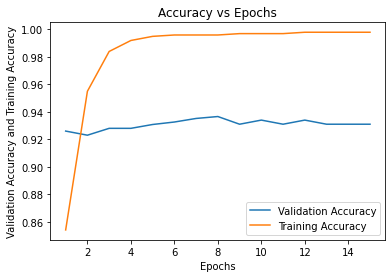

In [ ]:
plt.plot(range(1,16), val_acc, label='Validation Accuracy')
plt.plot(range(1,16), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

## 5e-5

In [ ]:
LR = 5e-5
epochs = [1,2,3,4,5,6,7,8,9,10]
test_acc =[]
val_acc=[]
train_acc=[]

checkpoint_path = '/content/drive/MyDrive/bert/checkpointsacclr5e-5/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelacclr5e-5/model.pt'

In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8750/8750 [54:22<00:00,  2.68it/s]


Epochs: 1 | Train Loss:  0.174                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (-inf --> 0.499800).  Saving model ...


100%|██████████| 8750/8750 [54:01<00:00,  2.70it/s]


Epochs: 2 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.499800 --> 0.500200).  Saving model ...


100%|██████████| 8750/8750 [53:02<00:00,  2.75it/s]


Epochs: 3 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.499


100%|██████████| 8750/8750 [52:48<00:00,  2.76it/s]


In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,10)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transf

In [ ]:
#epoch 4
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8750/8750 [54:43<00:00,  2.66it/s]
Epochs: 4 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.17

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transf

In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [51:44<00:00,  2.82it/s]
Epochs: 5 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
 44%|████▍     | 3887/8750 [23:00<28:51,  2.81it/s]


In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.

range(6, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [53:07<00:00,  2.75it/s]
Epochs: 6 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500200 --> 0.500200).  Saving model ...
100%|██████████| 8750/8750 [53:06<00:00,  2.75it/s]
Epochs: 7 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500200 --> 0.500200).  Saving model ...
100%|██████████| 8750/8750 [53:03<00:00,  2.75it/s]
Epochs: 8 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
100%|██████████| 8750/8750 [53:03<00:00,  2.75it/s]


In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predicti

range(9, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [54:46<00:00,  2.66it/s]


Epochs: 9 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [54:51<00:00,  2.66it/s]


Epochs: 10 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


In [ ]:
train_acc=[0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500]
val_acc=[0.499800,0.500200,0.499,0.500,0.500,0.500200,0.500200,0.500,0.500,0.500]

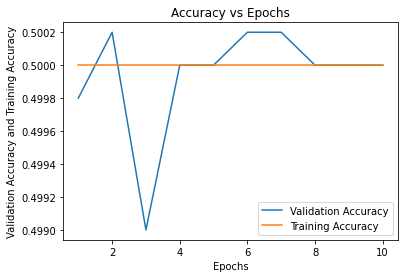

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

## 1e-5

In [ ]:
LR = 1e-5
epochs = [1,2,3,4,5,6,7,8,9,10]
test_acc =[]
val_acc=[]
train_acc=[]

checkpoint_path = '/content/drive/MyDrive/bert/checkpointsacclr1e-5/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelacclr1e-5/model.pt'

In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8750/8750 [55:55<00:00,  2.61it/s]


Epochs: 1 | Train Loss:  0.112                 | Train Accuracy:  0.756                 | Val Loss:  0.056                 | Val Accuracy:  0.918
Validation Accuracy increased (-inf --> 0.918400).  Saving model ...


100%|██████████| 8750/8750 [56:18<00:00,  2.59it/s]


Epochs: 2 | Train Loss:  0.046                 | Train Accuracy:  0.936                 | Val Loss:  0.049                 | Val Accuracy:  0.927
Validation Accuracy increased (0.918400 --> 0.926600).  Saving model ...


 24%|██▍       | 2133/8750 [13:44<42:20,  2.60it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,10)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


range(3, 10)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [58:27<00:00,  2.49it/s]


Epochs: 3 | Train Loss:  0.023                 | Train Accuracy:  0.971                 | Val Loss:  0.054                 | Val Accuracy:  0.928
Validation Accuracy increased (0.926600 --> 0.927600).  Saving model ...


100%|██████████| 8750/8750 [58:27<00:00,  2.49it/s]


Epochs: 4 | Train Loss:  0.013                 | Train Accuracy:  0.986                 | Val Loss:  0.057                 | Val Accuracy:  0.929
Validation Accuracy increased (0.927600 --> 0.929000).  Saving model ...


100%|██████████| 8750/8750 [58:35<00:00,  2.49it/s]


Epochs: 5 | Train Loss:  0.009                 | Train Accuracy:  0.991                 | Val Loss:  0.079                 | Val Accuracy:  0.927


 69%|██████▉   | 6035/8750 [40:29<18:09,  2.49it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


range(6, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [55:50<00:00,  2.61it/s]
Epochs: 6 | Train Loss:  0.007                 | Train Accuracy:  0.993                 | Val Loss:  0.080                 | Val Accuracy:  0.929
100%|██████████| 8750/8750 [55:49<00:00,  2.61it/s]
Epochs: 7 | Train Loss:  0.007                 | Train Accuracy:  0.992                 | Val Loss:  0.081                 | Val Accuracy:  0.932
Validation Accuracy increased (0.929000 --> 0.931600).  Saving model ...
 27%|██▋       | 2387/8750 [15:13<40:37,  2.61it/s]


In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transf

range(8, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [59:56<00:00,  2.43it/s]


Epochs: 8 | Train Loss:  0.005                 | Train Accuracy:  0.995                 | Val Loss:  0.092                 | Val Accuracy:  0.924


100%|██████████| 8750/8750 [59:49<00:00,  2.44it/s]


Epochs: 9 | Train Loss:  0.005                 | Train Accuracy:  0.994                 | Val Loss:  0.085                 | Val Accuracy:  0.931


100%|██████████| 8750/8750 [59:51<00:00,  2.44it/s]


Epochs: 10 | Train Loss:  0.004                 | Train Accuracy:  0.996                 | Val Loss:  0.101                 | Val Accuracy:  0.931


In [ ]:
val_acc=[0.918400,0.926600,0.927600,0.929000,0.927,0.929,0.931600,0.924,0.931,0.931]
train_acc=[0.756,0.936,0.971,0.986,0.991,0.993,0.992,0.995,0.994,0.996]

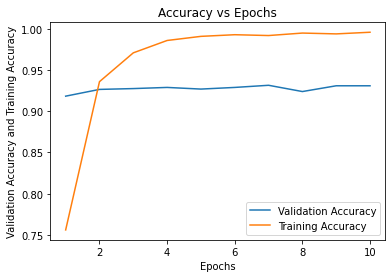

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

##1e-4

In [ ]:
LR = 1e-4
epochs = [1,2,3,4,5,6,7,8,9,10]
test_acc =[]
val_acc=[]
train_acc=[]
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsacclr1e-5/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelacclr1e-5/model.pt'

In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8750/8750 [52:51<00:00,  2.76it/s]


Epochs: 1 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (-inf --> 0.500000).  Saving model ...


100%|██████████| 8750/8750 [52:48<00:00,  2.76it/s]


Epochs: 2 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500200).  Saving model ...


100%|██████████| 8750/8750 [52:38<00:00,  2.77it/s]


Epochs: 3 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


 92%|█████████▏| 8066/8750 [48:32<04:06,  2.78it/s]

In [ ]:

# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_re

range(4, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)


100%|██████████| 8750/8750 [52:09<00:00,  2.80it/s]


Epochs: 4 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [52:06<00:00,  2.80it/s]


Epochs: 5 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [52:05<00:00,  2.80it/s]


Epochs: 6 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [52:05<00:00,  2.80it/s]


Epochs: 7 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [52:06<00:00,  2.80it/s]


Epochs: 8 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


 77%|███████▋  | 6758/8750 [40:13<11:51,  2.80it/s]

In [ ]:

# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.d

range(9, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)


100%|██████████| 8750/8750 [53:32<00:00,  2.72it/s]


Epochs: 9 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


100%|██████████| 8750/8750 [53:27<00:00,  2.73it/s]


Epochs: 10 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500


In [ ]:
val_acc=[0.500000,0.500200,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000]
train_acc=[0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500]

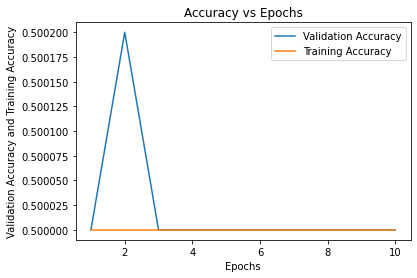

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

##1e-6

In [ ]:
LR=1e-6
EPOCHS = [1,2,3,4,5,6,7,8,9,10]
test_acc =[]
val_acc=[]
train_acc=[]
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsacclr1e-6/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelacclr1e-6/model.pt'

In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, -np.inf)

100%|██████████| 8750/8750 [59:25<00:00,  2.45it/s]
Epochs: 1 | Train Loss:  0.134                 | Train Accuracy:  0.671                 | Val Loss:  0.059                 | Val Accuracy:  0.912
Validation Accuracy increased (-inf --> 0.9117203).  Saving model ...
100%|██████████| 8750/8750 [56:12<00:00,  2.59it/s]
Epochs: 2 | Train Loss:  0.054                 | Train Accuracy:  0.922                 | Val Loss:  0.053                 | Val Accuracy:  0.920
Validation Accuracy increased (0.9117203 --> 0.920171).  Saving model ...
100%|██████████| 8750/8750 [56:15<00:00,  2.59it/s]
Epochs: 3 | Train Loss:  0.028                 | Train Accuracy:  0.964                 | Val Loss:  0.052                 | Val Accuracy:  0.928
Validation Accuracy increased (0.920171 --> 0.928114).  Saving model ...
100%|██████████| 8750/8750 [56:14<00:00,  2.59it/s]
Epochs: 4 | Train Loss:  0.013                 | Train Accuracy:  0.985                 | Val Loss:  0.068                 | Val Accuracy

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1, 10)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


range(5, 10)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [1:02:10<00:00,  2.35it/s]
Epochs: 5 | Train Loss:  0.009                 | Train Accuracy:  0.990                 | Val Loss:  0.077                 | Val Accuracy:  0.927
100%|██████████| 8750/8750 [1:02:10<00:00,  2.35it/s]
Epochs: 6 | Train Loss:  0.007                 | Train Accuracy:  0.992                 | Val Loss:  0.092                 | Val Accuracy:  0.918
100%|██████████| 8750/8750 [1:02:07<00:00,  2.35it/s]
Epochs: 7 | Train Loss:  0.006                 | Train Accuracy:  0.993                 | Val Loss:  0.096                 | Val Accuracy:  0.917
21%|██        | 1837/8750 [13:03<49:42,  2.32it/s]


In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1, 10)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


range(8, 10)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [57:02<00:00,  2.56it/s]
Epochs: 8 | Train Loss:  0.003                 | Train Accuracy:  0.998                 | Val Loss:  0.085                 | Val Accuracy:  0.934
Validation Accuracy increased (0.928114 --> 0.933610).  Saving model ...


In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_ ,_ , _ , valid_accuracy_max, _ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch, _ , LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1, 10)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predic

range(9, 10)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [56:52<00:00,  2.56it/s]
Epochs: 9 | Train Loss:  0.002                 | Train Accuracy:  0.999                 | Val Loss:  0.121                 | Val Accuracy:  0.936
Validation Accuracy increased (0.933610 --> 0.935600).  Saving model ...


In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_ ,_ , _ , valid_accuracy_max, _ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch, _ , LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1, 11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.prediction

In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [53:40<00:00,  2.72it/s]
Epochs: 10 | Train Loss:  0.002                 | Train Accuracy:  0.999                 | Val Loss:  0.121                 | Val Accuracy:  0.935


In [ ]:
val_acc=[0.912,0.920,0.928,0.925,0.927,0.918,0.917,0.934,0.936,0.935]
train_acc=[0.671,0.922,0.964,0.985,0.990,0.992,0.993,0.998,0.999,0.999]

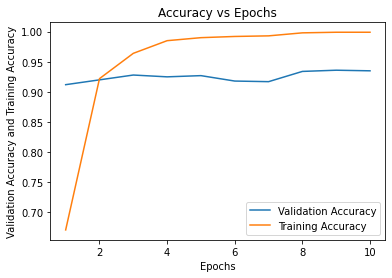

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

##1e-3

In [ ]:
LR = 1e-3
EPOCHS = [1,2,3,4,5,6,7,8,9,10]
test_acc =[]
val_acc=[]
train_acc=[]

checkpoint_path = '/content/drive/MyDrive/bert/checkpointsacclr1e-3/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelacclr1e-3/model.pt'

In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_accuracy(model, train_data, validation_data, LR, range(1,10),checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [53:57<00:00,  2.70it/s]


Epochs: 1 | Train Loss:  0.174                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (-inf --> 0.500000).  Saving model ...


 81%|████████  | 7103/8750 [43:43<10:06,  2.72it/s]

In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_ ,_ , _ , valid_accuracy_max, _ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch, _ , LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1, 11)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.

In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [54:21<00:00,  2.68it/s]


Epochs: 2 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


100%|██████████| 8750/8750 [54:17<00:00,  2.69it/s]


Epochs: 3 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


100%|██████████| 8750/8750 [54:16<00:00,  2.69it/s]


Epochs: 4 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_ ,_ , _ , valid_accuracy_max, _ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch, _ , LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1, 11)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.

In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [54:21<00:00,  2.68it/s]
Epochs: 5 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...
100%|██████████| 8750/8750 [54:17<00:00,  2.69it/s]
Epochs: 6 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...
100%|██████████| 8750/8750 [54:16<00:00,  2.69it/s]
Epochs: 7 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...
100%|██████████| 8750/8750 [54:16<00:00,  2.69it/s]
Epochs: 8 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accura

In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_ ,_ , _ , valid_accuracy_max, _ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch, _ , LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1, 11)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.

In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [53:40<00:00,  2.72it/s]
Epochs: 9 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_ ,_ , _ , valid_accuracy_max, _ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch, _ , LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1, 11)

In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [53:40<00:00,  2.72it/s]


Epochs: 10 | Train Loss:  0.173                 | Train Accuracy:  0.500                 | Val Loss:  0.173                 | Val Accuracy:  0.500
Validation Accuracy increased (0.500000 --> 0.500000).  Saving model ...


In [ ]:
val_acc=[0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000]
train_acc=[0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500]

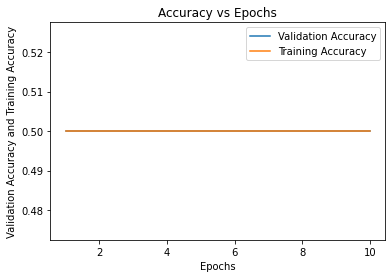

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

# Best From all lr

In [ ]:
# graph comparing between best validation accuracies of the different learning rates
lr=[1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3]
# for 5e-6
val_acc_5e6=[0.926,0.923,0.928,0.928,0.9308,0.9326,0.935200,0.936600,0.931,0.934,0.931,0.934,0.931,0.931,0.931]
# for 1e-5
val_acc_1e5=[0.918400,0.926600,0.927600,0.929000,0.927,0.929,0.931600,0.924,0.931,0.931]
# for 5e-5
val_acc_5e5=[0.499800,0.500200,0.499,0.500,0.500,0.500200,0.500200,0.500,0.500,0.500]
# for 1e-4
val_acc_1e4=[0.500000,0.500200,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000]
# for 1e-6
val_acc_1e6=[0.912,0.920,0.928,0.925,0.927,0.918,0.917,0.934,0.936,0.935]
# for 1e-3
val_acc_1e3=[0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000]
#get max validation accuracy for each learning rate
max_val_acc=[max(val_acc_5e6),max(val_acc_1e5),max(val_acc_5e5),max(val_acc_1e4),max(val_acc_1e6),max(val_acc_1e3)]

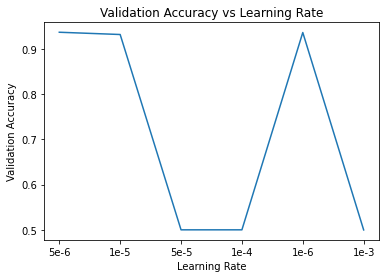

In [ ]:
# plot max validation accuracy for each learning rate
import matplotlib.pyplot as plt

lr=['5e-6','1e-5','5e-5','1e-4','1e-6','1e-3']
plt.plot(lr, max_val_acc, label='Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Learning Rate')
plt.show()


# Best Model

# Bonus

## 768,64,128,256,128,64,2

In [ ]:
from torch.nn.modules import linear
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout_1 = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(768,64)
        self.dropout_2 = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(64, 128)
        self.dropout_3 = nn.Dropout(dropout)
        self.linear_3 = nn.Linear(128, 256)
        self.dropout_4 = nn.Dropout(dropout)
        self.linear_4= nn.Linear(256, 128)
        self.dropout_5 = nn.Dropout(dropout)
        self.linear_5= nn.Linear(128, 64)
        self.dropout_6 = nn.Dropout(dropout)
        self.linear_6= nn.Linear(64, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout_1(pooled_output)
        linear_output_1 = self.linear_1(dropout_output)
        dropout_output_1 = self.dropout_2(linear_output_1)
        linear_output_2 = self.linear_2(dropout_output_1)
        dropout_output_2 = self.dropout_3(linear_output_2)
        linear_output_3 = self.linear_3(dropout_output_2)
        dropout_output_3 = self.dropout_4(linear_output_3)
        linear_output_4 = self.linear_4(dropout_output_3)
        dropout_output_4 = self.dropout_5(linear_output_4)
        linear_output_5 = self.linear_5(dropout_output_4)
        dropout_output_5 = self.dropout_6(linear_output_5)
        linear_output_6 = self.linear_6(dropout_output_5)
        final_layer = self.relu(linear_output_6)
        return final_layer

### 1e-6

In [ ]:
model = BertClassifier()
LR = 1e-6
optimizer = Adam(model.parameters(), lr= LR)
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsaccbonus/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelaccbonus/model.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

100%|██████████| 8750/8750 [57:51<00:00,  2.52it/s]


Epochs: 1 | Train Loss:  0.093                 | Train Accuracy:  0.892                 | Val Loss:  0.071                 | Val Accuracy:  0.918
Validation Accuracy increased (-inf --> 0.917600).  Saving model ...


100%|██████████| 8750/8750 [57:46<00:00,  2.52it/s]


Epochs: 2 | Train Loss:  0.058                 | Train Accuracy:  0.934                 | Val Loss:  0.058                 | Val Accuracy:  0.926
Validation Accuracy increased (0.917600 --> 0.926400).  Saving model ...


 20%|██        | 1764/8750 [11:35<45:42,  2.55it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predicti

range(3, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [1:00:18<00:00,  2.42it/s]


Epochs: 3 | Train Loss:  0.043                 | Train Accuracy:  0.955                 | Val Loss:  0.059                 | Val Accuracy:  0.926


100%|██████████| 8750/8750 [1:00:17<00:00,  2.42it/s]


Epochs: 4 | Train Loss:  0.030                 | Train Accuracy:  0.970                 | Val Loss:  0.061                 | Val Accuracy:  0.930
Validation Accuracy increased (0.926400 --> 0.929800).  Saving model ...


 38%|███▊      | 3345/8750 [23:02<37:05,  2.43it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight

range(5, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [58:06<00:00,  2.51it/s]


Epochs: 5 | Train Loss:  0.021                 | Train Accuracy:  0.982                 | Val Loss:  0.065                 | Val Accuracy:  0.928


100%|██████████| 8750/8750 [58:02<00:00,  2.51it/s]


Epochs: 6 | Train Loss:  0.014                 | Train Accuracy:  0.990                 | Val Loss:  0.101                 | Val Accuracy:  0.909


100%|██████████| 8750/8750 [58:00<00:00,  2.51it/s]


Epochs: 7 | Train Loss:  0.009                 | Train Accuracy:  0.994                 | Val Loss:  0.097                 | Val Accuracy:  0.928


 72%|███████▏  | 6327/8750 [41:56<15:56,  2.53it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predic

range(8, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [58:10<00:00,  2.51it/s]


Epochs: 8 | Train Loss:  0.007                 | Train Accuracy:  0.996                 | Val Loss:  0.098                 | Val Accuracy:  0.929


100%|██████████| 8750/8750 [58:05<00:00,  2.51it/s]


Epochs: 9 | Train Loss:  0.005                 | Train Accuracy:  0.997                 | Val Loss:  0.118                 | Val Accuracy:  0.923


 30%|██▉       | 2623/8750 [17:24<40:29,  2.52it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerN

range(10, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [57:10<00:00,  2.55it/s]


Epochs: 10 | Train Loss:  0.004                 | Train Accuracy:  0.997                 | Val Loss:  0.120                 | Val Accuracy:  0.926


In [ ]:
val_acc=[0.917600,0.926400,0.926,0.929800,0.928,0.909,0.928,0.929,0.923,0.9256]
train_acc=[0.892,0.934,0.955,0.970,0.982,0.990,0.994,0.996,0.997,0.997]

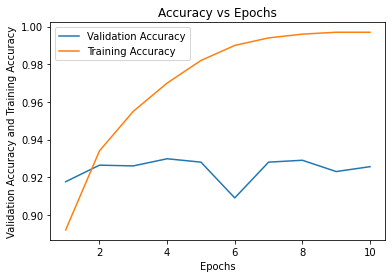

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

### 5e-6

In [ ]:
model = BertClassifier()
LR = 5e-6
optimizer = Adam(model.parameters(), lr= LR)
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsaccbonus/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelaccbonus/model.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

100%|██████████| 8750/8750 [57:46<00:00,  2.52it/s]


Epochs: 1 | Train Loss:  0.055                 | Train Accuracy:  0.926                 | Val Loss:  0.050                 | Val Accuracy:  0.929
Validation Accuracy increased (-inf --> 0.928600).  Saving model ...


100%|██████████| 8750/8750 [57:44<00:00,  2.53it/s]


Epochs: 2 | Train Loss:  0.028                 | Train Accuracy:  0.967                 | Val Loss:  0.053                 | Val Accuracy:  0.934
Validation Accuracy increased (0.928600 --> 0.934000).  Saving model ...


 93%|█████████▎| 8151/8750 [53:46<03:57,  2.52it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias',

range(3, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [55:39<00:00,  2.62it/s]


Epochs: 3 | Train Loss:  0.012                 | Train Accuracy:  0.988                 | Val Loss:  0.075                 | Val Accuracy:  0.932


100%|██████████| 8750/8750 [55:32<00:00,  2.63it/s]


Epochs: 4 | Train Loss:  0.007                 | Train Accuracy:  0.993                 | Val Loss:  0.086                 | Val Accuracy:  0.934
Validation Accuracy increased (0.934000 --> 0.934400).  Saving model ...


100%|██████████| 8750/8750 [55:27<00:00,  2.63it/s]


Epochs: 5 | Train Loss:  0.006                 | Train Accuracy:  0.995                 | Val Loss:  0.097                 | Val Accuracy:  0.923


 87%|████████▋ | 7606/8750 [48:07<07:11,  2.65it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.prediction

range(6, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [57:33<00:00,  2.53it/s]


Epochs: 6 | Train Loss:  0.005                 | Train Accuracy:  0.996                 | Val Loss:  0.119                 | Val Accuracy:  0.932


100%|██████████| 8750/8750 [57:24<00:00,  2.54it/s]


Epochs: 7 | Train Loss:  0.004                 | Train Accuracy:  0.997                 | Val Loss:  0.113                 | Val Accuracy:  0.931


 33%|███▎      | 2916/8750 [19:07<38:22,  2.53it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight',

range(8, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [57:31<00:00,  2.54it/s]


Epochs: 8 | Train Loss:  0.004                 | Train Accuracy:  0.997                 | Val Loss:  0.136                 | Val Accuracy:  0.928


100%|██████████| 8750/8750 [57:33<00:00,  2.53it/s]


Epochs: 9 | Train Loss:  0.003                 | Train Accuracy:  0.997                 | Val Loss:  0.136                 | Val Accuracy:  0.929


100%|██████████| 8750/8750 [57:14<00:00,  2.55it/s]


Epochs: 10 | Train Loss:  0.002                 | Train Accuracy:  0.998                 | Val Loss:  0.168                 | Val Accuracy:  0.932


In [ ]:
val_acc=[0.928600,0.934000,0.932,0.934,0.923,0.932,0.931,0.928, 0.9292, 0.932]
train_acc=[0.926,0.967,0.988,0.993,0.995,0.996,0.997,0.997,0.997,0.998]

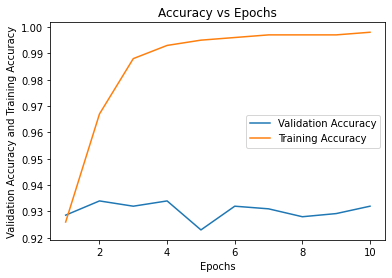

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

### 1e-5

In [ ]:
model = BertClassifier()
LR = 1e-5
optimizer = Adam(model.parameters(), lr= LR)
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsaccbonus/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelaccbonus/model.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

100%|██████████| 8750/8750 [56:30<00:00,  2.58it/s]


Epochs: 1 | Train Loss:  0.099                 | Train Accuracy:  0.802                 | Val Loss:  0.055                 | Val Accuracy:  0.918
Validation Accuracy increased (-inf --> 0.918000).  Saving model ...


100%|██████████| 8750/8750 [56:42<00:00,  2.57it/s]


Epochs: 2 | Train Loss:  0.043                 | Train Accuracy:  0.944                 | Val Loss:  0.047                 | Val Accuracy:  0.933
Validation Accuracy increased (0.918000 --> 0.932600).  Saving model ...


100%|██████████| 8750/8750 [56:41<00:00,  2.57it/s]


Epochs: 3 | Train Loss:  0.019                 | Train Accuracy:  0.978                 | Val Loss:  0.067                 | Val Accuracy:  0.927


100%|██████████| 8750/8750 [56:33<00:00,  2.58it/s]


Epochs: 4 | Train Loss:  0.010                 | Train Accuracy:  0.989                 | Val Loss:  0.081                 | Val Accuracy:  0.933
Validation Accuracy increased (0.932600 --> 0.932800).  Saving model ...


100%|██████████| 8750/8750 [56:31<00:00,  2.58it/s]


Epochs: 5 | Train Loss:  0.007                 | Train Accuracy:  0.993                 | Val Loss:  0.081                 | Val Accuracy:  0.928


100%|██████████| 8750/8750 [56:24<00:00,  2.59it/s]


Epochs: 6 | Train Loss:  0.006                 | Train Accuracy:  0.994                 | Val Loss:  0.099                 | Val Accuracy:  0.933


 12%|█▏        | 1092/8750 [07:03<49:07,  2.60it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predicti

range(7, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [54:59<00:00,  2.65it/s]


Epochs: 7 | Train Loss:  0.005                 | Train Accuracy:  0.994                 | Val Loss:  0.104                 | Val Accuracy:  0.931


100%|██████████| 8750/8750 [55:08<00:00,  2.64it/s]


Epochs: 8 | Train Loss:  0.005                 | Train Accuracy:  0.995                 | Val Loss:  0.112                 | Val Accuracy:  0.926


100%|██████████| 8750/8750 [54:59<00:00,  2.65it/s]


Epochs: 9 | Train Loss:  0.005                 | Train Accuracy:  0.995                 | Val Loss:  0.118                 | Val Accuracy:  0.925


 76%|███████▌  | 6636/8750 [41:48<13:16,  2.65it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerN

range(10, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [57:19<00:00,  2.54it/s]


Epochs: 10 | Train Loss:  0.005                 | Train Accuracy:  0.996                 | Val Loss:  0.113                 | Val Accuracy:  0.925


In [ ]:
val_acc=[0.918000,0.932600,0.927,0.932800,0.928,0.932600,0.931,0.926,0.925,0.925]
train_acc=[0.802,0.944,0.978,0.989,0.993,0.994,0.994,0.995,0.995,0.996]

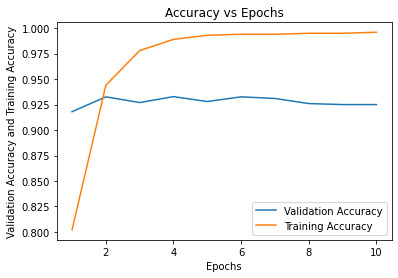

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

### Best from all lr

In [ ]:
# for 5e-6
val_acc_5e6=[0.928600,0.934000,0.932,0.934,0.923,0.932,0.931,0.928, 0.9292, 0.932]
# for 1e-5
val_acc_1e5=[0.918000,0.932600,0.927,0.932800,0.928,0.932600,0.931,0.926,0.925,0.925]
# for 1e-6
val_acc_1e6=[0.917600,0.926400,0.926,0.929800,0.928,0.909,0.928,0.929,0.923,0.9256]


#get max validation accuracy for each learning rate
max_val_acc=[max(val_acc_5e6),max(val_acc_1e5),max(val_acc_1e6)]

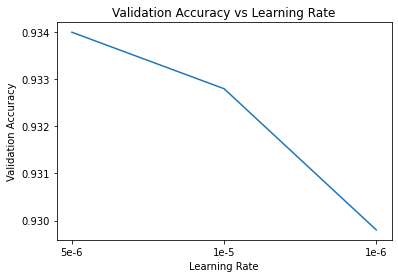

In [ ]:
# plot max validation accuracy for each learning rate
lr=['5e-6','1e-5','1e-6']
plt.plot(lr, max_val_acc, label='Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Learning Rate')
plt.show()

### Best Model

In [ ]:
def conf_mat(test_labels,pred_labels):
      conf_matrix = confusion_matrix(test_labels, pred_labels)
      fig, ax = plt.subplots(figsize=(5, 5))
      ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
      for i in range(conf_matrix.shape[0]):
          for j in range(conf_matrix.shape[1]):
              ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

      plt.xlabel('Predictions', fontsize=18)
      plt.ylabel('Actuals', fontsize=18)
      plt.title('Confusion Matrix', fontsize=18)
      plt.show()

In [ ]:
test_labels=[]
pred_labels=[]

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

              test_labels.append(test_label.cpu().numpy()[0])
              test_labels.append(test_label.cpu().numpy()[1])
              pred_labels.append(output.argmax(dim=1).cpu().numpy()[0])
              pred_labels.append(output.argmax(dim=1).cpu().numpy()[1])

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')



In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
LR = 5e-6
optimizer = Adam(model.parameters(), lr= LR)
best_model = '/content/drive/MyDrive/bert/bestmodelaccbonus/model.pt'
model, optimizer, best_epoch,valid_accuracy_max, LR= load_model_accuracy(best_model, model, optimizer)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
LR

5e-06

In [ ]:
best_epoch

4

In [ ]:
valid_accuracy_max

0.9344

In [ ]:
evaluate(model, test_data)

Test Accuracy:  0.934


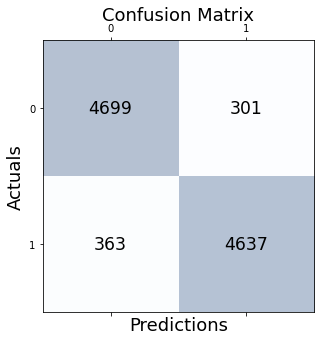

In [ ]:
conf_mat(test_labels,pred_labels)

In [ ]:
def evalscore(tp,tn,fp,fn):
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  specificity=tn/(tn+fp)
  f1=(2*precision*recall)/(precision+recall)

  print(f'F1-score:    {f1:.3f}')
  print(f'Precision:   {precision:.3f}')
  print(f'Recall:      {recall:.3f}')
  print(f'Specificity: {specificity:.3f}')

In [ ]:
tp=4699
tn=4637
fp=363
fn=301

evalscore(tp,tn,fp,fn)

F1-score:    0.934
Precision:   0.928
Recall:      0.940
Specificity: 0.927


##768,32,128,512,128,32,2

In [ ]:
from torch.nn.modules import linear
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout_1 = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(768,32)
        self.dropout_2 = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(32, 128)
        self.dropout_3 = nn.Dropout(dropout)
        self.linear_3 = nn.Linear(128, 512)
        self.dropout_4 = nn.Dropout(dropout)
        self.linear_4= nn.Linear(512, 128)
        self.dropout_5 = nn.Dropout(dropout)
        self.linear_5= nn.Linear(128, 32)
        self.dropout_6 = nn.Dropout(dropout)
        self.linear_6= nn.Linear(32, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout_1(pooled_output)
        linear_output_1 = self.linear_1(dropout_output)
        dropout_output_1 = self.dropout_2(linear_output_1)
        linear_output_2 = self.linear_2(dropout_output_1)
        dropout_output_2 = self.dropout_3(linear_output_2)
        linear_output_3 = self.linear_3(dropout_output_2)
        dropout_output_3 = self.dropout_4(linear_output_3)
        linear_output_4 = self.linear_4(dropout_output_3)
        dropout_output_4 = self.dropout_5(linear_output_4)
        linear_output_5 = self.linear_5(dropout_output_4)
        dropout_output_5 = self.dropout_6(linear_output_5)
        linear_output_6 = self.linear_6(dropout_output_5)
        final_layer = self.relu(linear_output_6)

        return final_layer

###1e-6

In [ ]:
model = BertClassifier()
LR = 1e-6
checkpoint_path = '/content/drive/MyDrive/bonus/checkpoints/check.pt'
best_model = '/content/drive/MyDrive/bonus/bestmodel/model.pt'

In [ ]:
EPOCHS =[1,2,3,4,5,6,7,8,9,10]
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model,-np.Inf)

100%|██████████| 8750/8750 [53:01<00:00,  2.75it/s]


Epochs: 1 | Train Loss:  0.165                 | Train Accuracy:  0.558                 | Val Loss:  0.137                 | Val Accuracy:  0.737
Validation Accuracy increased (-inf --> 0.737000).  Saving model ...


100%|██████████| 8750/8750 [53:42<00:00,  2.72it/s]


Epochs: 2 | Train Loss:  0.097                 | Train Accuracy:  0.860                 | Val Loss:  0.074                 | Val Accuracy:  0.901
Validation Accuracy increased (0.737000 --> 0.900600).  Saving model ...


100%|██████████| 8750/8750 [53:51<00:00,  2.71it/s]


Epochs: 3 | Train Loss:  0.060                 | Train Accuracy:  0.929                 | Val Loss:  0.059                 | Val Accuracy:  0.917
Validation Accuracy increased (0.900600 --> 0.916800).  Saving model ...


100%|██████████| 8750/8750 [53:51<00:00,  2.71it/s]


Epochs: 4 | Train Loss:  0.045                 | Train Accuracy:  0.952                 | Val Loss:  0.060                 | Val Accuracy:  0.923
Validation Accuracy increased (0.916800 --> 0.923000).  Saving model ...


100%|██████████| 8750/8750 [53:51<00:00,  2.71it/s]


Epochs: 5 | Train Loss:  0.033                 | Train Accuracy:  0.971                 | Val Loss:  0.072                 | Val Accuracy:  0.925
Validation Accuracy increased (0.923000 --> 0.924600).  Saving model ...


100%|██████████| 8750/8750 [53:48<00:00,  2.71it/s]


Epochs: 6 | Train Loss:  0.022                 | Train Accuracy:  0.983                 | Val Loss:  0.076                 | Val Accuracy:  0.920


  2%|▏         | 138/8750 [00:51<52:38,  2.73it/s]

In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_ ,_ , _ , valid_accuracy_max, _ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch, _ , LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
epochs = range(start_epoch+1, 11)
print(epochs)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_re

range(7, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model,valid_accuracy_max)

100%|██████████| 8750/8750 [55:54<00:00,  2.61it/s]


Epochs: 7 | Train Loss:  0.016                 | Train Accuracy:  0.990                 | Val Loss:  0.091                 | Val Accuracy:  0.924


100%|██████████| 8750/8750 [55:51<00:00,  2.61it/s]


Epochs: 8 | Train Loss:  0.013                 | Train Accuracy:  0.994                 | Val Loss:  0.108                 | Val Accuracy:  0.921


100%|██████████| 8750/8750 [55:50<00:00,  2.61it/s]


Epochs: 9 | Train Loss:  0.011                 | Train Accuracy:  0.994                 | Val Loss:  0.142                 | Val Accuracy:  0.907


100%|██████████| 8750/8750 [55:50<00:00,  2.61it/s]


Epochs: 10 | Train Loss:  0.010                 | Train Accuracy:  0.995                 | Val Loss:  0.118                 | Val Accuracy:  0.921


In [ ]:
val_acc=[0.737,0.901,0.917,0.923,0.925,0.920,0.924,0.921,0.907, 0.921]
train_acc=[0.558,0.860,0.929,0.952,0.971,0.983,0.990,0.994,0.994,0.995]

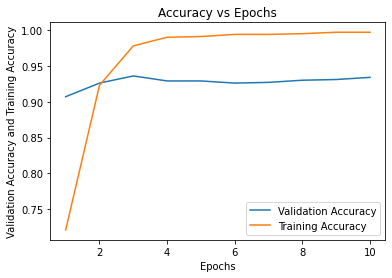

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

###1e-5

In [ ]:
# EPOCHS = 5
model = BertClassifier()
LR = 1e-5
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsacc/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelacc/t.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8750/8750 [56:51<00:00,  2.56it/s]


Epochs: 1 | Train Loss:  0.127                 | Train Accuracy:  0.721                 | Val Loss:  0.065                 | Val Accuracy:  0.907
Validation Accuracy increased (-inf --> 0.907000).  Saving model ...


100%|██████████| 8750/8750 [57:29<00:00,  2.54it/s]


Epochs: 2 | Train Loss:  0.057                 | Train Accuracy:  0.923                 | Val Loss:  0.052                 | Val Accuracy:  0.926
Validation Accuracy increased (0.907000 --> 0.926000).  Saving model ...


 63%|██████▎   | 5474/8750 [35:53<21:33,  2.53it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerN

range(3, 11)


In [ ]:
#epoch 3
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)


100%|██████████| 8750/8750 [56:54<00:00,  2.56it/s]


Epochs: 3 | Train Loss:  0.021                 | Train Accuracy:  0.978                 | Val Loss:  0.056                 | Val Accuracy:  0.936
Validation Accuracy increased (0.933000 --> 0.936000).  Saving model ...


 57%|█████▋    | 4979/8750 [32:18<24:31,  2.56it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predicti

range(4, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [56:18<00:00,  2.59it/s]


Epochs: 4 | Train Loss:  0.011                 | Train Accuracy:  0.990                 | Val Loss:  0.090                 | Val Accuracy:  0.929


100%|██████████| 8750/8750 [55:29<00:00,  2.63it/s]


Epochs: 5 | Train Loss:  0.008                 | Train Accuracy:  0.991                 | Val Loss:  0.097                 | Val Accuracy:  0.929


100%|██████████| 8750/8750 [55:15<00:00,  2.64it/s]


Epochs: 6 | Train Loss:  0.006                 | Train Accuracy:  0.994                 | Val Loss:  0.127                 | Val Accuracy:  0.926


100%|██████████| 8750/8750 [55:07<00:00,  2.65it/s]


Epochs: 7 | Train Loss:  0.006                 | Train Accuracy:  0.994                 | Val Loss:  0.095                 | Val Accuracy:  0.927


100%|██████████| 8750/8750 [55:04<00:00,  2.65it/s]


Epochs: 8 | Train Loss:  0.005                 | Train Accuracy:  0.995                 | Val Loss:  0.123                 | Val Accuracy:  0.930


 65%|██████▍   | 5678/8750 [35:59<19:50,  2.58it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls

range(9, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [55:13<00:00,  2.64it/s]


Epochs: 9 | Train Loss:  0.004                 | Train Accuracy:  0.997                 | Val Loss:  0.113                 | Val Accuracy:  0.931


100%|██████████| 8750/8750 [55:18<00:00,  2.64it/s]


Epochs: 10 | Train Loss:  0.003                 | Train Accuracy:  0.997                 | Val Loss:  0.110                 | Val Accuracy:  0.934


In [4]:
train_acc=[0.721,0.923 ,0.978,0.990,0.991,0.994,0.994 ,0.995,0.997,0.997]
val_acc=[0.907, 0.926 , 0.936 ,0.929, 0.929, 0.926  ,0.927, 0.930, 0.931 , 0.934]

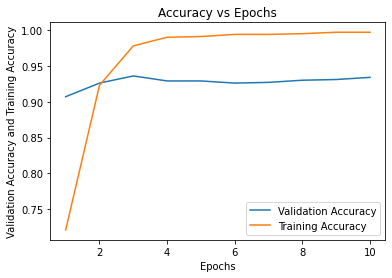

In [5]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

###5e-6

In [ ]:
# EPOCHS = 5
model = BertClassifier()
LR = 5e-6
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsacc/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelacc/t.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8750/8750 [55:02<00:00,  2.65it/s]


Epochs: 1 | Train Loss:  0.095                 | Train Accuracy:  0.829                 | Val Loss:  0.056                 | Val Accuracy:  0.922
Validation Accuracy increased (-inf --> 0.921600).  Saving model ...


100%|██████████| 8750/8750 [55:12<00:00,  2.64it/s]


Epochs: 2 | Train Loss:  0.043                 | Train Accuracy:  0.948                 | Val Loss:  0.056                 | Val Accuracy:  0.919


100%|██████████| 8750/8750 [55:13<00:00,  2.64it/s]


Epochs: 3 | Train Loss:  0.021                 | Train Accuracy:  0.979                 | Val Loss:  0.070                 | Val Accuracy:  0.924
Validation Accuracy increased (0.921600 --> 0.924400).  Saving model ...


100%|██████████| 8750/8750 [55:06<00:00,  2.65it/s]


Epochs: 4 | Train Loss:  0.010                 | Train Accuracy:  0.991                 | Val Loss:  0.085                 | Val Accuracy:  0.930
Validation Accuracy increased (0.924400 --> 0.929600).  Saving model ...


100%|██████████| 8750/8750 [54:58<00:00,  2.65it/s]


Epochs: 5 | Train Loss:  0.007                 | Train Accuracy:  0.994                 | Val Loss:  0.106                 | Val Accuracy:  0.929


100%|██████████| 8750/8750 [54:42<00:00,  2.67it/s]


Epochs: 6 | Train Loss:  0.005                 | Train Accuracy:  0.995                 | Val Loss:  0.096                 | Val Accuracy:  0.930
Validation Accuracy increased (0.929600 --> 0.930400).  Saving model ...


 17%|█▋        | 1500/8750 [09:21<45:04,  2.68it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.

range(7, 11)


In [ ]:
#epoch 3
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)


100%|██████████| 8750/8750 [54:37<00:00,  2.67it/s]


Epochs: 7 | Train Loss:  0.004                 | Train Accuracy:  0.996                 | Val Loss:  0.115                 | Val Accuracy:  0.931
Validation Accuracy increased (0.930400 --> 0.931200).  Saving model ...


100%|██████████| 8750/8750 [54:25<00:00,  2.68it/s]


Epochs: 8 | Train Loss:  0.004                 | Train Accuracy:  0.997                 | Val Loss:  0.129                 | Val Accuracy:  0.931


100%|██████████| 8750/8750 [54:16<00:00,  2.69it/s]


Epochs: 9 | Train Loss:  0.003                 | Train Accuracy:  0.997                 | Val Loss:  0.160                 | Val Accuracy:  0.928


100%|██████████| 8750/8750 [54:04<00:00,  2.70it/s]


Epochs: 10 | Train Loss:  0.003                 | Train Accuracy:  0.997                 | Val Loss:  0.141                 | Val Accuracy:  0.931


In [ ]:
val_acc=[0.922, 0.919 ,0.924,  0.930,0.929, 0.930,0.931,0.931,0.928,0.931]
train_acc=[ 0.829,  0.948, 0.979 , 0.991, 0.994  ,0.995, 0.996,0.997, 0.997 , 0.997 ]

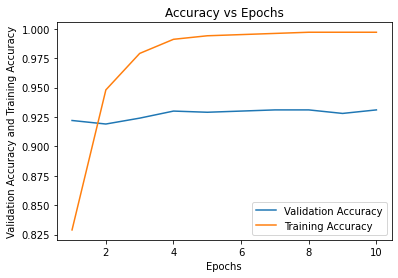

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

###Best from all lr

In [1]:
# for 5e-6
val_acc_5e6=[0.922, 0.919 ,0.924,  0.930,0.929, 0.930,0.931,0.931,0.928,0.931]
# for 1e-5
val_acc_1e5=[0.907, 0.926 , 0.936 ,0.929, 0.929, 0.926  ,0.927, 0.930, 0.931 , 0.934]
# for 1e-6
val_acc_1e6=[0.737,0.901,0.917,0.923,0.925,0.920,0.924,0.921,0.907, 0.921]


#get max validation accuracy for each learning rate
max_val_acc=[max(val_acc_5e6),max(val_acc_1e5),max(val_acc_1e6)]

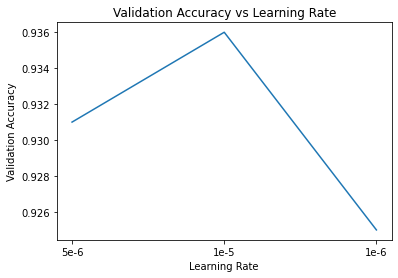

In [3]:
# plot max validation accuracy for each learning rate
lr=['5e-6','1e-5','1e-6']
plt.plot(lr, max_val_acc, label='Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Learning Rate')
plt.show()

###Best Model

In [ ]:
def conf_mat(test_labels,pred_labels):
      conf_matrix = confusion_matrix(test_labels, pred_labels)
      fig, ax = plt.subplots(figsize=(5, 5))
      ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
      for i in range(conf_matrix.shape[0]):
          for j in range(conf_matrix.shape[1]):
              ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

      plt.xlabel('Predictions', fontsize=18)
      plt.ylabel('Actuals', fontsize=18)
      plt.title('Confusion Matrix', fontsize=18)
      plt.show()

In [ ]:
test_labels=[]
pred_labels=[]

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

              test_labels.append(test_label.cpu().numpy()[0])
              test_labels.append(test_label.cpu().numpy()[1])
              pred_labels.append(output.argmax(dim=1).cpu().numpy()[0])
              pred_labels.append(output.argmax(dim=1).cpu().numpy()[1])

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
LR = 1e-5
optimizer = Adam(model.parameters(), lr= LR)
best_model = '/content/drive/MyDrive/bert/bestmodelacc/t.pt'
model, optimizer, best_epoch,valid_accuracy_max, LR= load_model_accuracy(best_model, model, optimizer)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
LR

1e-05

In [ ]:
best_epoch


3

In [ ]:
valid_accuracy_max

0.936

In [ ]:
evaluate(model, test_data)

Test Accuracy:  0.929


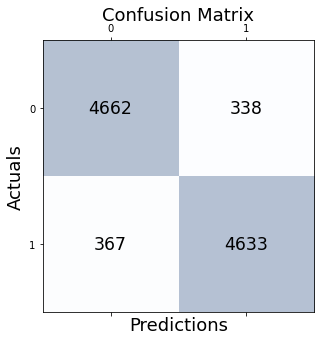

In [ ]:
conf_mat(test_labels,pred_labels)

In [ ]:
def evalscore(tp,tn,fp,fn):
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  specificity=tn/(tn+fp)
  f1=(2*precision*recall)/(precision+recall)

  print(f'F1-score:    {f1:.3f}')
  print(f'Precision:   {precision:.3f}')
  print(f'Recall:      {recall:.3f}')
  print(f'Specificity: {specificity:.3f}')

In [ ]:
tp=4662
tn=4633
fp=367
fn=338

evalscore(tp,tn,fp,fn)

F1-score:    0.930
Precision:   0.927
Recall:      0.932
Specificity: 0.927


## 768,1024,256,16,4

In [ ]:
from torch.nn.modules import linear
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout_1 = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(768,1024)
        self.dropout_2 = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(1024, 256)
        self.dropout_3 = nn.Dropout(dropout)
        self.linear_3 = nn.Linear(256, 16)
        self.dropout_4 = nn.Dropout(dropout)
        self.linear_4= nn.Linear(16, 4)
        self.dropout_5 = nn.Dropout(dropout)
        self.linear_5= nn.Linear(4, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout_1(pooled_output)
        linear_output_1 = self.linear_1(dropout_output)
        dropout_output_1 = self.dropout_2(linear_output_1)
        linear_output_2 = self.linear_2(dropout_output_1)
        dropout_output_2 = self.dropout_3(linear_output_2)
        linear_output_3 = self.linear_3(dropout_output_2)
        dropout_output_3 = self.dropout_4(linear_output_3)
        linear_output_4 = self.linear_4(dropout_output_3)
        dropout_output_4 = self.dropout_5(linear_output_4)
        linear_output_5 = self.linear_5(dropout_output_4)
        final_layer = self.relu(linear_output_5)
        return final_layer

### 1e-6

In [ ]:
model = BertClassifier()
LR = 1e-6
optimizer = Adam(model.parameters(), lr= LR)
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsaccbonus2/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelaccbonus2/model.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

100%|██████████| 8750/8750 [56:44<00:00,  2.57it/s]


Epochs: 1 | Train Loss:  0.148                 | Train Accuracy:  0.677                 | Val Loss:  0.116                 | Val Accuracy:  0.813
Validation Accuracy increased (-inf --> 0.813200).  Saving model ...


100%|██████████| 8750/8750 [57:09<00:00,  2.55it/s]


Epochs: 2 | Train Loss:  0.105                 | Train Accuracy:  0.833                 | Val Loss:  0.102                 | Val Accuracy:  0.832
Validation Accuracy increased (0.813200 --> 0.831600).  Saving model ...


100%|██████████| 8750/8750 [57:12<00:00,  2.55it/s]


Epochs: 3 | Train Loss:  0.091                 | Train Accuracy:  0.855                 | Val Loss:  0.098                 | Val Accuracy:  0.839
Validation Accuracy increased (0.831600 --> 0.839000).  Saving model ...


 30%|██▉       | 2610/8750 [17:03<40:01,  2.56it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relati

range(4, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [56:08<00:00,  2.60it/s]


Epochs: 4 | Train Loss:  0.082                 | Train Accuracy:  0.869                 | Val Loss:  0.093                 | Val Accuracy:  0.843
Validation Accuracy increased (0.839000 --> 0.843400).  Saving model ...


100%|██████████| 8750/8750 [56:10<00:00,  2.60it/s]


Epochs: 5 | Train Loss:  0.073                 | Train Accuracy:  0.884                 | Val Loss:  0.097                 | Val Accuracy:  0.846
Validation Accuracy increased (0.843400 --> 0.846000).  Saving model ...


100%|██████████| 8750/8750 [56:07<00:00,  2.60it/s]


Epochs: 6 | Train Loss:  0.066                 | Train Accuracy:  0.891                 | Val Loss:  0.096                 | Val Accuracy:  0.851
Validation Accuracy increased (0.846000 --> 0.850600).  Saving model ...


 74%|███████▎  | 6439/8750 [41:17<14:48,  2.60it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'c

range(7, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [56:19<00:00,  2.59it/s]


Epochs: 7 | Train Loss:  0.059                 | Train Accuracy:  0.899                 | Val Loss:  0.103                 | Val Accuracy:  0.850


100%|██████████| 8750/8750 [56:16<00:00,  2.59it/s]


Epochs: 8 | Train Loss:  0.055                 | Train Accuracy:  0.905                 | Val Loss:  0.118                 | Val Accuracy:  0.848


 56%|█████▋    | 4938/8750 [31:43<24:29,  2.59it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predicti

range(9, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [57:55<00:00,  2.52it/s]


Epochs: 9 | Train Loss:  0.052                 | Train Accuracy:  0.910                 | Val Loss:  0.128                 | Val Accuracy:  0.856
Validation Accuracy increased (0.850600 --> 0.856400).  Saving model ...


100%|██████████| 8750/8750 [57:59<00:00,  2.51it/s]


Epochs: 10 | Train Loss:  0.049                 | Train Accuracy:  0.910                 | Val Loss:  0.127                 | Val Accuracy:  0.852


In [ ]:
val_acc=[0.813,0.832,0.839,0.843,0.846,0.851,0.850,0.848,0.8564,0.8518]
train_acc=[0.677,0.833,0.855,0.869,0.884,0.891,0.899,0.905,0.910,0.910]

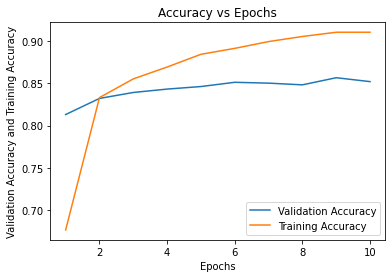

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

### 5e-6

In [ ]:
model = BertClassifier()
LR = 5e-6
optimizer = Adam(model.parameters(), lr= LR)
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsaccbonus2/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelaccbonus2/model.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

100%|██████████| 8750/8750 [56:46<00:00,  2.57it/s]


Epochs: 1 | Train Loss:  0.108                 | Train Accuracy:  0.792                 | Val Loss:  0.089                 | Val Accuracy:  0.836
Validation Accuracy increased (-inf --> 0.836000).  Saving model ...


100%|██████████| 8750/8750 [57:00<00:00,  2.56it/s]


Epochs: 2 | Train Loss:  0.077                 | Train Accuracy:  0.860                 | Val Loss:  0.085                 | Val Accuracy:  0.834


100%|██████████| 8750/8750 [56:55<00:00,  2.56it/s]


Epochs: 3 | Train Loss:  0.062                 | Train Accuracy:  0.889                 | Val Loss:  0.076                 | Val Accuracy:  0.865
Validation Accuracy increased (0.836000 --> 0.864800).  Saving model ...


 74%|███████▍  | 6517/8750 [42:17<14:21,  2.59it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predic

range(4, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [55:57<00:00,  2.61it/s]


Epochs: 4 | Train Loss:  0.048                 | Train Accuracy:  0.907                 | Val Loss:  0.097                 | Val Accuracy:  0.869
Validation Accuracy increased (0.864800 --> 0.868600).  Saving model ...


100%|██████████| 8750/8750 [55:47<00:00,  2.61it/s]


Epochs: 5 | Train Loss:  0.042                 | Train Accuracy:  0.917                 | Val Loss:  0.103                 | Val Accuracy:  0.871
Validation Accuracy increased (0.868600 --> 0.871000).  Saving model ...


 71%|███████   | 6217/8750 [39:34<16:09,  2.61it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relati

range(6, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [56:26<00:00,  2.58it/s]


Epochs: 6 | Train Loss:  0.036                 | Train Accuracy:  0.923                 | Val Loss:  0.113                 | Val Accuracy:  0.873
Validation Accuracy increased (0.871000 --> 0.873000).  Saving model ...


100%|██████████| 8750/8750 [56:10<00:00,  2.60it/s]


Epochs: 7 | Train Loss:  0.033                 | Train Accuracy:  0.927                 | Val Loss:  0.107                 | Val Accuracy:  0.879
Validation Accuracy increased (0.873000 --> 0.878800).  Saving model ...


100%|██████████| 8750/8750 [56:02<00:00,  2.60it/s]


Epochs: 8 | Train Loss:  0.031                 | Train Accuracy:  0.930                 | Val Loss:  0.157                 | Val Accuracy:  0.876


100%|██████████| 8750/8750 [55:54<00:00,  2.61it/s]


Epochs: 9 | Train Loss:  0.029                 | Train Accuracy:  0.929                 | Val Loss:  0.137                 | Val Accuracy:  0.866


100%|██████████| 8750/8750 [55:51<00:00,  2.61it/s]


Epochs: 10 | Train Loss:  0.029                 | Train Accuracy:  0.931                 | Val Loss:  0.162                 | Val Accuracy:  0.881
Validation Accuracy increased (0.878800 --> 0.880600).  Saving model ...


In [ ]:
val_acc=[0.836000,0.834,0.864800,0.868600,0.871000,0.873000,0.878800,0.876,0.866,0.880600]
train_acc=[0.792,0.860,0.889,0.907,0.917,0.923,0.927,0.930,0.929,0.931]

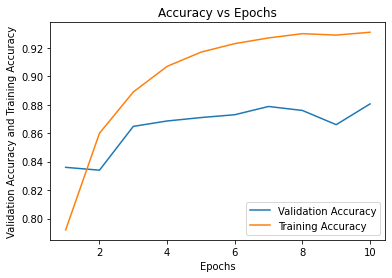

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

### 1e-5

In [ ]:
model = BertClassifier()
LR = 1e-5
optimizer = Adam(model.parameters(), lr= LR)
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsaccbonus2/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelaccbonus2/model.pt'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_accuracy(model, train_data, validation_data, LR, epochs,checkpoint_path, best_model, -np.inf)

100%|██████████| 8750/8750 [55:23<00:00,  2.63it/s]


Epochs: 1 | Train Loss:  0.114                 | Train Accuracy:  0.770                 | Val Loss:  0.090                 | Val Accuracy:  0.851
Validation Accuracy increased (-inf --> 0.850800).  Saving model ...


100%|██████████| 8750/8750 [55:36<00:00,  2.62it/s]


Epochs: 2 | Train Loss:  0.079                 | Train Accuracy:  0.869                 | Val Loss:  0.081                 | Val Accuracy:  0.865
Validation Accuracy increased (0.850800 --> 0.865200).  Saving model ...


100%|██████████| 8750/8750 [55:26<00:00,  2.63it/s]


Epochs: 3 | Train Loss:  0.058                 | Train Accuracy:  0.900                 | Val Loss:  0.080                 | Val Accuracy:  0.868
Validation Accuracy increased (0.865200 --> 0.867800).  Saving model ...


 89%|████████▉ | 7784/8750 [49:14<06:03,  2.65it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relation

range(4, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [54:40<00:00,  2.67it/s]


Epochs: 4 | Train Loss:  0.045                 | Train Accuracy:  0.931                 | Val Loss:  0.081                 | Val Accuracy:  0.876
Validation Accuracy increased (0.867800 --> 0.876400).  Saving model ...


100%|██████████| 8750/8750 [54:22<00:00,  2.68it/s]


Epochs: 5 | Train Loss:  0.034                 | Train Accuracy:  0.951                 | Val Loss:  0.091                 | Val Accuracy:  0.900
Validation Accuracy increased (0.876400 --> 0.899600).  Saving model ...


 65%|██████▍   | 5663/8750 [35:00<19:18,  2.66it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.

range(6, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [58:08<00:00,  2.51it/s]


Epochs: 6 | Train Loss:  0.029                 | Train Accuracy:  0.953                 | Val Loss:  0.126                 | Val Accuracy:  0.898


100%|██████████| 8750/8750 [57:54<00:00,  2.52it/s]


Epochs: 7 | Train Loss:  0.023                 | Train Accuracy:  0.957                 | Val Loss:  0.175                 | Val Accuracy:  0.901
Validation Accuracy increased (0.899600 --> 0.901200).  Saving model ...


100%|██████████| 8750/8750 [57:42<00:00,  2.53it/s]


Epochs: 8 | Train Loss:  0.019                 | Train Accuracy:  0.961                 | Val Loss:  0.310                 | Val Accuracy:  0.900


 44%|████▍     | 3853/8750 [25:27<32:23,  2.52it/s]

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
_,_, _, valid_accuracy_max,_ = load_model_accuracy(best_model, model, optimizer)
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer, start_epoch,_, LR = load_ckp_accuracy(checkpoint_path, model, optimizer)
EPOCHS = range(start_epoch+1,11)
print(EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_rela

range(9, 11)


In [ ]:
train_accuracy(model, train_data, validation_data, LR, EPOCHS,checkpoint_path, best_model, valid_accuracy_max)

100%|██████████| 8750/8750 [55:40<00:00,  2.62it/s]


Epochs: 9 | Train Loss:  0.019                 | Train Accuracy:  0.960                 | Val Loss:  0.175                 | Val Accuracy:  0.902
Validation Accuracy increased (0.901200 --> 0.901600).  Saving model ...


100%|██████████| 8750/8750 [55:47<00:00,  2.61it/s]


Epochs: 10 | Train Loss:  0.022                 | Train Accuracy:  0.959                 | Val Loss:  0.141                 | Val Accuracy:  0.900


In [ ]:
val_acc=[0.850800,0.865200,0.867800,0.876400,0.899600,0.898,0.901200,0.900,0.9016, 0.9]
train_acc=[0.770,0.869,0.900,0.931,0.951,0.953,0.957,0.961,0.960,0.959]

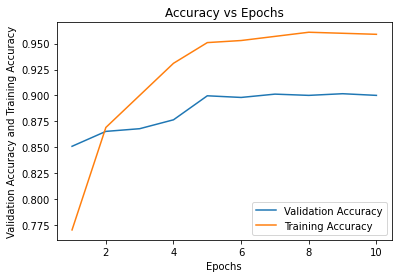

In [ ]:
plt.plot(range(1,11), val_acc, label='Validation Accuracy')
plt.plot(range(1,11), train_acc, label='Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy and Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.show()

### Best from all lr

In [ ]:
# for 5e-6
val_acc_5e6=[0.836000,0.834,0.864800,0.868600,0.871000,0.873000,0.878800,0.876,0.866,0.880600]
# for 1e-5
val_acc_1e5=[0.850800,0.865200,0.867800,0.876400,0.899600,0.898,0.901200,0.900,0.9016, 0.9]
# for 1e-6
val_acc_1e6=[0.813,0.832,0.839,0.843,0.846,0.851,0.850,0.848,0.8564,0.8518]


#get max validation accuracy for each learning rate
max_val_acc=[max(val_acc_5e6),max(val_acc_1e5),max(val_acc_1e6)]

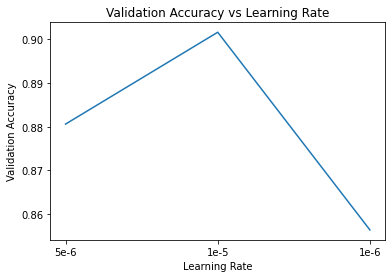

In [ ]:
# plot max validation accuracy for each learning rate
lr=['5e-6','1e-5','1e-6']
plt.plot(lr, max_val_acc, label='Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Learning Rate')
plt.show()

### Best Model

In [ ]:
# reload ckp and start training from the last epoch
model = BertClassifier()
LR = 1e-5
optimizer = Adam(model.parameters(), lr= LR)
best_model = '/content/drive/MyDrive/bert/bestmodelaccbonus2/model.pt'
model, optimizer, best_epoch,valid_accuracy_max, LR= load_model_accuracy(best_model, model, optimizer)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
LR

1e-05

In [ ]:
best_epoch

9

In [ ]:
valid_accuracy_max

0.9016

In [ ]:
evaluate(model, test_data)

Test Accuracy:  0.895


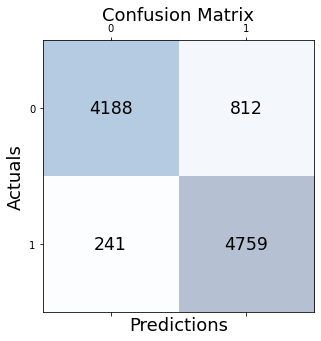

In [ ]:
conf_mat(test_labels,pred_labels)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix as mcm ,  classification_report
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89      5000
           1       0.85      0.95      0.90      5000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



In [ ]:
def evalscore(tp,tn,fp,fn):
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  specificity=tn/(tn+fp)
  f1=(2*precision*recall)/(precision+recall)

  print(f'F1-score:    {f1:.3f}')
  print(f'Precision:   {precision:.3f}')
  print(f'Recall:      {recall:.3f}')
  print(f'Specificity: {specificity:.3f}')

In [ ]:
tp=4188
tn=4759
fp=241
fn=812

evalscore(tp,tn,fp,fn)

F1-score:    0.888
Precision:   0.946
Recall:      0.838
Specificity: 0.952


# Testing Overall Best Model

In [ ]:
checkpoint_path = '/content/drive/MyDrive/bert/checkpointsacc/check.pt'
best_model = '/content/drive/MyDrive/bert/bestmodelacc/model.pt'

In [ ]:
model = BertClassifier()
optimizer = Adam(model.parameters(), lr= LR)
model, optimizer,best_epoch,valid_accuracy_max, LR = load_model_accuracy(best_model, model, optimizer)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
LR

5e-06

In [ ]:
best_epoch

8

In [ ]:
valid_accuracy_max

0.9366

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import multilabel_confusion_matrix as mcm ,  classification_report
pred_labels =[]
test_labels=[]
def evaluate(model, test_data):

    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
              test_label = test_label.to(device)
              
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
              test_labels.append(test_label.cpu().numpy()[0])
              test_labels.append(test_label.cpu().numpy()[1])
              pred_labels.append(output.argmax(dim=1).cpu().numpy()[0])
              pred_labels.append(output.argmax(dim=1).cpu().numpy()[1])

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
evaluate(model, test_data)

Test Accuracy:  0.935


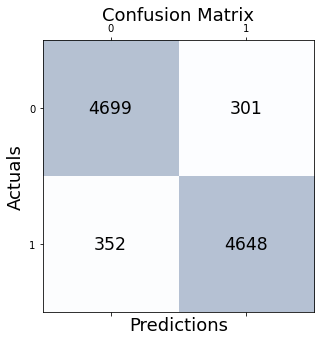

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_labels, pred_labels)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
def evalscore(tp,tn,fp,fn):
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  specificity=tn/(tn+fp)
  f1=(2*precision*recall)/(precision+recall)

  print(f'F1-score:    {f1:.3f}')
  print(f'Precision:   {precision:.3f}')
  print(f'Recall:      {recall:.3f}')
  print(f'Specificity: {specificity:.3f}')

In [ ]:
tp=4699
tn=4648
fp=352
fn=301

evalscore(tp,tn,fp,fn)

F1-score:    0.935
Precision:   0.930
Recall:      0.940
Specificity: 0.930
